In [1]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# define and move to dataset directory
datasetdir = '/content/drive/MyDrive/Capstone/plant_disease_detection/dataset/Plant_leaf_diseases_dataset_with_augmentation'
import os
os.chdir(datasetdir)

In [3]:
# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [4]:
print('Num GPU Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPU Available:  1


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 30

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1)

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width),
        batch_size = batch_size,
        subset = 'training')

    val_dataset = imgdatagen.flow_from_directory(
        os.getcwd(),
        target_size = (height, width),
        batch_size = batch_size,
        subset = 'validation')
    
    return train_dataset, val_dataset

In [6]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [7]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_acc')>0.97):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True

__VGG19__

In [8]:
vgg19 = keras.applications.vgg19
conv_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers: 
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)
predictions = keras.layers.Dense(15, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [9]:
train_dataset, val_dataset = generators((224,224), preprocessing=vgg19.preprocess_input)

Found 22852 images belonging to 15 classes.
Found 2536 images belonging to 15 classes.


In [10]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=['acc'])

In [11]:
callbacks = myCallback()
history = full_model.fit(
    train_dataset, 
    validation_data = val_dataset,
    epochs=200,
    steps_per_epoch=5,
    callbacks = [callbacks])

Epoch 1/200
5/5 [==============================] - 619s 144s/step - loss: 7.6473 - acc: 0.1533 - val_loss: 4.2110 - val_acc: 0.4566
Epoch 2/200
5/5 [==============================] - 51s 11s/step - loss: 3.3063 - acc: 0.5600 - val_loss: 2.4769 - val_acc: 0.5942
Epoch 3/200
5/5 [==============================] - 49s 10s/step - loss: 2.0336 - acc: 0.5867 - val_loss: 1.9826 - val_acc: 0.6317
Epoch 4/200
5/5 [==============================] - 50s 11s/step - loss: 1.8114 - acc: 0.6000 - val_loss: 1.3130 - val_acc: 0.6964
Epoch 5/200
5/5 [==============================] - 50s 10s/step - loss: 0.7370 - acc: 0.7733 - val_loss: 1.2358 - val_acc: 0.6956
Epoch 6/200
5/5 [==============================] - 48s 10s/step - loss: 1.0013 - acc: 0.7000 - val_loss: 0.9568 - val_acc: 0.7307
Epoch 7/200
5/5 [==============================] - 49s 11s/step - loss: 0.5768 - acc: 0.7933 - val_loss: 0.7515 - val_acc: 0.7744
Epoch 8/200
5/5 [==============================] - 47s 10s/step - loss: 0.6297 - acc: 0.

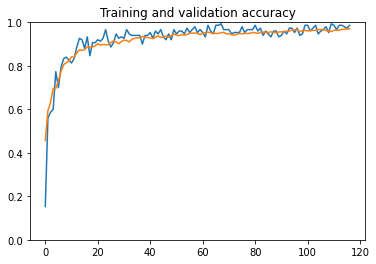

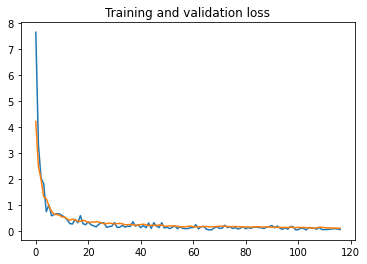

In [12]:
plot_history(history, yrange=(0,1))

In [15]:
# save the model in SavedModel format
full_model.save("saved_model")

INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
# !zip -r /content/model.zip /content/drive/MyDrive/Capstone/plant_disease_detection/model

In [17]:
# load SavedModel model
model = keras.models.load_model('/content/drive/MyDrive/Capstone/plant_disease_detection/saved_model/')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

__Predict Image__

In [18]:
class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves',
               'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight',
               'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
               'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy']

In [19]:
image_path = '/content/drive/MyDrive/Capstone/plant_disease_detection/Corn___Cercospora_leaf_spot Gray_leaf_spot_test_image.png'

In [20]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

In [21]:
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [22]:
image_test = preprocess_input(img_batch)

In [23]:
prediction = model.predict(image_test)[0]

In [24]:
print(prediction)

[1.3185204e-05 2.5563156e-09 2.7342210e-02 1.1626063e-05 9.1999164e-04
 9.0360880e-01 1.0324057e-07 6.8096921e-02 3.0701297e-06 1.1792499e-11
 8.4489624e-09 7.0324097e-10 8.1320970e-08 2.3555836e-07 3.7739264e-06]


In [25]:
class_names[np.argmax(prediction)]

'Corn___Cercospora_leaf_spot Gray_leaf_spot'

__TFLite Model__

In [26]:
# convert SavedModel to tflite
saved_model_dir = '/content/drive/MyDrive/Capstone/plant_disease_detection/saved_model/'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# save tflite model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)